In [1]:
"""
    Import necessary library functions
"""
import numpy as np
from scipy.ndimage import affine_transform
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
"""
    Convenient functions
"""
def display_slice(img_array: np.array, img_slice: int=96):
    """
        Display slice of image
    """
    # make a figure (no axis)
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    
    # grab the selected slice to display
    selected_slice = img_array[img_slice,:,:].T
    
    # plot selected slice
    ax.imshow(selected_slice,origin='lower',cmap='gray')

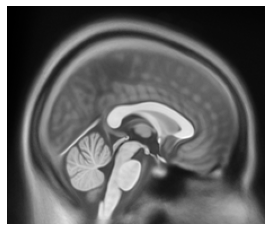

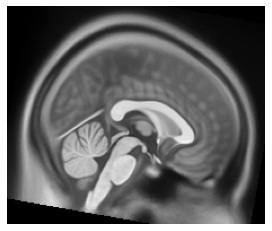

In [3]:
"""
    Read in image data from disk
"""
# We first load in the image data into python using nibabel
# Nibabel automatically reads in the NIFTI header information
# alongside the actual image data
#
# We'll use the affine information in the header to project
# the data onto physical coordiantes from it's array-based
# voxel coordinate representation
#
# NOTE: as a grounf truth the mover image is simply the fixed
# image rotated by 45 degrees on the x-axis
fixed_img = nib.load("fixed.nii.gz")
mover_img = nib.load("mover.nii.gz")

# Display images
display_slice(fixed_img.get_fdata())
display_slice(mover_img.get_fdata())

In [4]:
"""
    Define initial affine transform
"""
# We define an initial 4x4 matrix to start the
# affine registration process. Note that this will
# be the inverse affine matrix (from fixed --> mover)
# rather than the forward affine matrix since we tend to
# interpolation is more easily done on a fixed grid
#
# A general good choice for initialization
# is setting the matrix to identiry
#
# If prior knowledge is known about the transform
# it is possible set the initial affine matrix
# to that
affine_mat = np.eye(4)

# Now we need to account for the physical coordinates of each image
# we will augment the affine matrix with the voxel --> physical
# affines that are in the headers of the fixed and moving images
#
# Since the affine is the inverse transfrom we concatenate the
# matrices by matrix multiplying from fixed_affine -->
# affine_mat --> inverse_mover_affine
transform_mat = np.matmul(
    np.linalg.inv(mover_img.affine),
    np.matmul(affine_mat,fixed_img.affine))
print("Transform Matrix: ")
print(transform_mat)

# To make this operation more conveinent during registration,
# we can write a function
def affine_sandwich(affine_mat: np.array, no_move=False):
    # if no_move = True, don't apply moving image affine
    if no_move:
        return np.matmul(affine_mat, fixed_img.affine)
    else:
        return np.matmul(np.linalg.inv(mover_img.affine), np.matmul(affine_mat, fixed_img.affine))

Transform Matrix: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [5]:
"""
    Define the objective function
"""
# We'll use a sum of squared differences (L2) objective function
def objective_function(mover_array: np.array, fixed_array: np.array):
    """
        Calculates SSD between mover image and fixed image
        
        mover and fixed image are the vectorizaed versions of the image
        e.g. mover_img.get_fdata().ravel()
    """
    return np.linalg.norm(mover_array - fixed_array)**2

# Now let's test it on the two images
print("Objective function Value: {}".format(
    objective_function(mover_img.get_fdata().ravel(), fixed_img.get_fdata().ravel())
))

Objective function Value: 1631556179.1508267


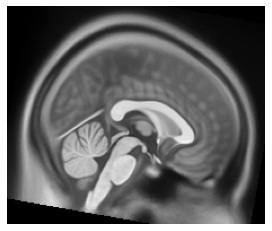

In [6]:
"""
    Apply affine transformation to moving image
"""
# Let's create an empty array of the same size of the fixed image
# to fill in. This will allow us to interpolate over the grid of
# the fixed image
#
# In this particular case, this doesn't matter too much since the
# moving and fixed image are of the same dimensions/resolution.
# However, this does matter in the case of images of differing
# dimensions/resolutions
new_moving_img = np.zeros(fixed_img.shape)

# Now let's apply an affine transform to the moving image
#
# We are going to use the affine_transform function from the scipy
# library. Internally, this use a b-spline interpolation method
# to interpolate between voxel values.
#
# If you read the documentation for the function, you'll note that
# it accepts the inverse of the forward transform for the reasons
# stated above.
affine_transform(
    mover_img.get_fdata(),
    transform_mat,
    output=new_moving_img
)

# display the new image with the affine transform applied
display_slice(new_moving_img)

In [7]:
"""
    Calculate gradient
"""
# Now we need a way to calculate the gradient to solve the
# optimization problem
#
# We can use the analytical gradient solution for the L2 objective
# function, and code an expression for the gradient
# given any affine matrix
def calculate_gradient(moving_img: np.array, affine_mat: np.array):
    # calculate residual term
    residual = moving_img.ravel() - fixed_img.get_fdata().ravel()
    
    # grab the mover image header
    mover_dim = [1,1,1]
    
    # calculate image gradients
    igradient = np.gradient(moving_img, *mover_dim, edge_order=2)
    igradient_x = igradient[0].ravel()
    igradient_y = igradient[1].ravel()
    igradient_z = igradient[2].ravel()
    
    # calculate position gradient
    # Note that our choice of grid is arbitrary
    #
    # It is much easier to start with the fixed image's grid and find
    # the position of each voxel on the moving image's grid
    #
    # we use a meshgrid to define each voxel in the fixed image then
    # use our previously defined affine_sandwich function to calculate the positions
    # of the voxels in the moving image

    # get grid of target image
    fixed_x, fixed_y, fixed_z = np.meshgrid(
        np.arange(fixed_img.shape[0]),
        np.arange(fixed_img.shape[1]),
        np.arange(fixed_img.shape[2]),
        indexing='ij'
    )
    
    # flatten arrays and concatenate
    ones = np.ones(fixed_x.ravel().shape)
    fixed_positions = np.stack((fixed_x.ravel(),fixed_y.ravel(),fixed_z.ravel(),ones), axis=0)

    # get the affine mapping from fixed --> moving
    affine_map = affine_sandwich(affine_mat,no_move=True)
    moving_positions = np.matmul(affine_map,fixed_positions)
    moving_x = moving_positions[0,:]
    moving_y = moving_positions[1,:]
    moving_z = moving_positions[2,:]
   
    # stack the new positions into proper gradient matrix
    ones = np.ones(moving_x.ravel().shape)
    pos_gradient = np.stack((moving_x,moving_y,moving_z,ones),axis=1)
    
    # combine position and image gradients
    ip_gradient_x = igradient_x[:,np.newaxis]*pos_gradient
    ip_gradient_y = igradient_y[:,np.newaxis]*pos_gradient
    ip_gradient_z = igradient_z[:,np.newaxis]*pos_gradient
    ip_gradient = np.concatenate((ip_gradient_x,ip_gradient_y,ip_gradient_z),axis=1)
    
    # combine with residual and return as matrix
    gradient = np.dot(ip_gradient.T,residual)
    return np.stack((gradient[0:4],gradient[4:8],gradient[8:12],[0,0,0,1]),axis=0)

# print initial gradient values
initial_gradient = calculate_gradient(new_moving_img, affine_mat)
print(initial_gradient)

[[-9.19056745e+08  3.01003456e-06  2.40802765e-05 -2.30036676e-07]
 [-2.32458115e-06 -1.11721012e+09 -7.96774413e+08  2.63726115e+07]
 [ 1.99079514e-05  3.50160406e+09 -1.64100237e+09 -7.81253608e+07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


[[ 1.00091906e+00 -3.01003456e-18 -2.40802765e-17  2.30036676e-19]
 [ 2.32458115e-18  1.00111721e+00  7.96774413e-04 -2.63726115e-05]
 [-1.99079514e-17 -3.50160406e-03  1.00164100e+00  7.81253608e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00143315e+00 -2.35438347e-18  2.32458115e-17  5.39701432e-19]
 [ 2.68220901e-18  1.00169915e+00  1.69540269e-03 -4.98817812e-05]
 [-8.57114792e-17 -6.02814079e-03  1.00047166e+00  1.85984126e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00180349e+00  2.89082527e-18  3.42130661e-17  2.42493115e-19]
 [-5.51342964e-18  1.00211803e+00  2.66573295e-03 -7.19091681e-05]
 [-1.13844872e-16 -8.49973627e-03  9.99233031e-01  2.94178953e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00207350e+00  2.62260437e-18  2.74181366e-17 -7.86385499e-20]
 [-2.20537186e-18  1.00242068e+00  3.69937367e-03 -9.27235449e-05]
 [-9.88245010e-17 -1.09257474e-02  9.98705518e-01  3.932208

<ipython-input-2-39ac7ba7e754>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


[[ 1.00224824e+00  3.99459386e-17 -3.55243683e-17 -2.66247662e-18]
 [-1.51693821e-17  1.00135394e+00  3.11480341e-02 -3.56714570e-04]
 [ 1.08957291e-16 -5.29844829e-02  9.95013826e-01  1.98657637e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00221575e+00  2.95561040e-17 -6.74724579e-17 -2.18983041e-18]
 [-2.21580267e-17  1.00121672e+00  3.30450816e-02 -3.67883245e-04]
 [ 1.66058540e-16 -5.51703627e-02  9.94870994e-01  2.06718160e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00218315e+00  4.02253354e-17 -6.52074814e-17 -2.69484008e-18]
 [-1.94162130e-17  1.00107554e+00  3.49681864e-02 -3.78810980e-04]
 [ 5.38825989e-17 -5.73466341e-02  9.94742349e-01  2.14686684e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00215041e+00  3.08748567e-17 -6.93798065e-17 -2.66340794e-18]
 [-2.38865614e-17  1.00093102e+00  3.69171830e-02 -3.89496276e-04]
 [ 9.19103622e-17 -5.95112155e-02  9.94618939e-01  2.225731

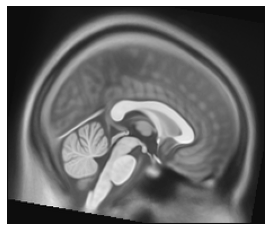

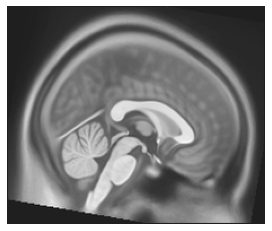

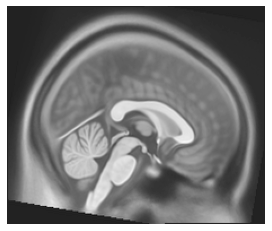

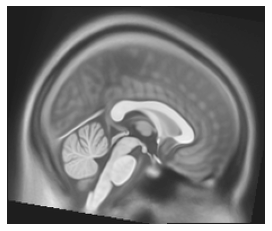

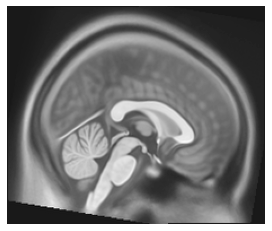

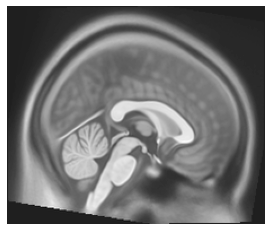

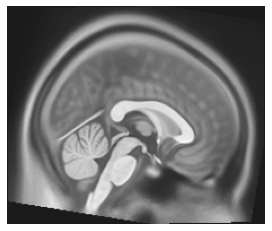

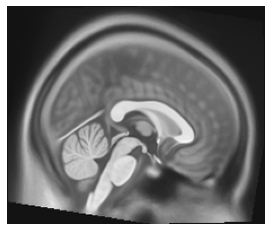

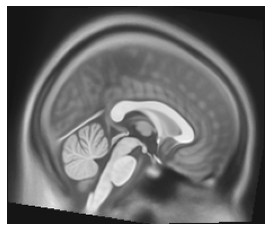

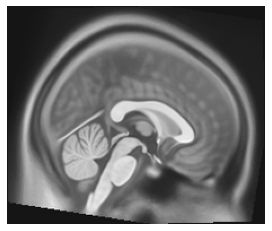

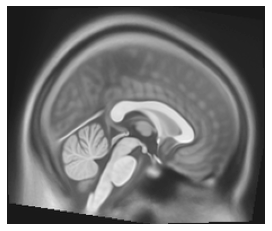

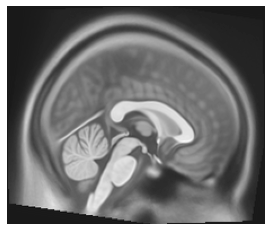

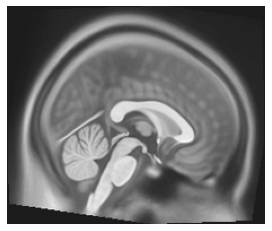

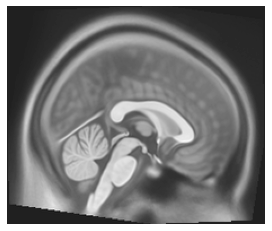

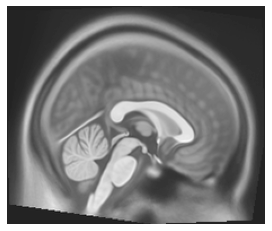

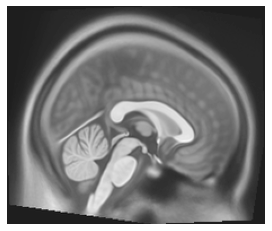

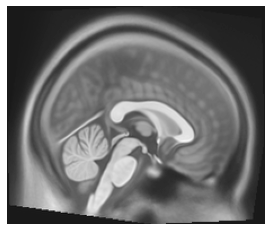

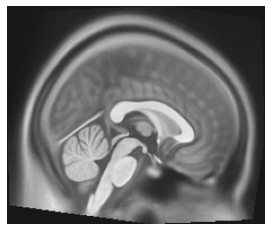

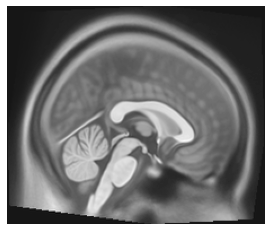

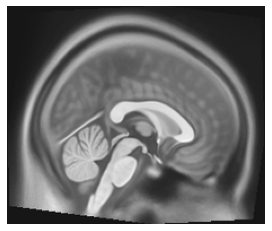

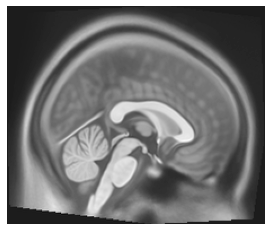

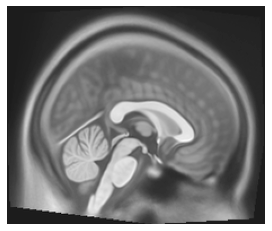

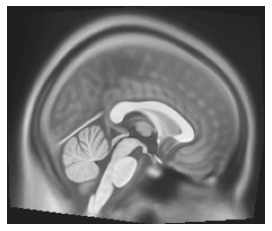

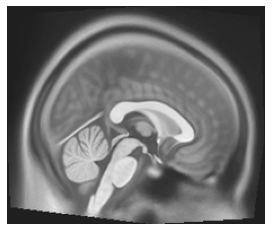

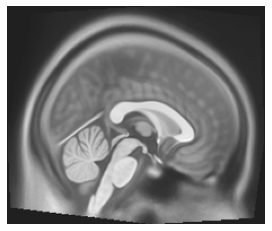

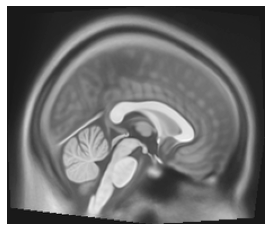

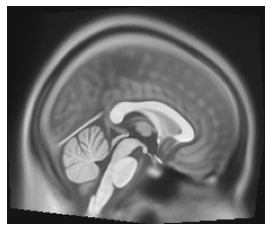

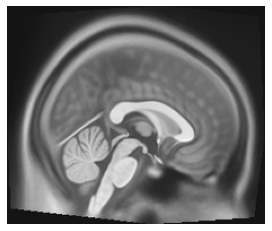

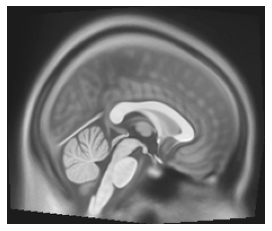

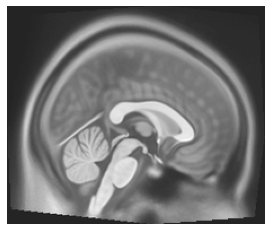

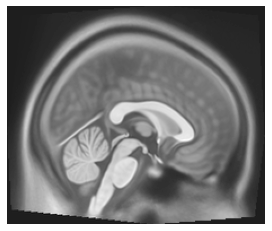

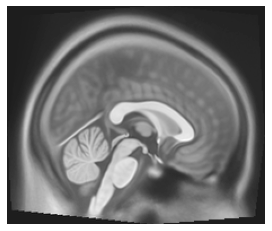

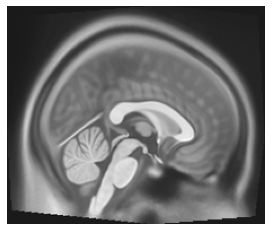

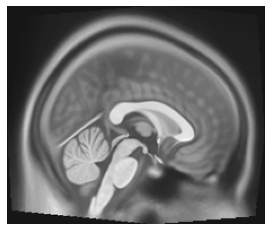

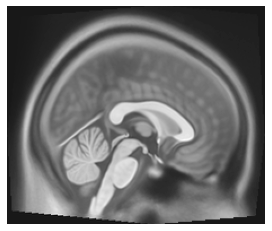

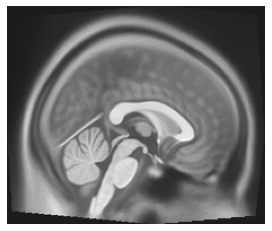

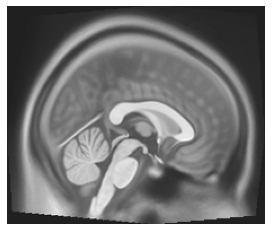

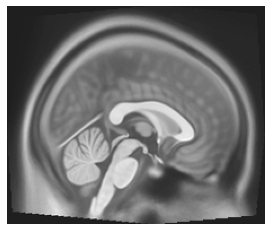

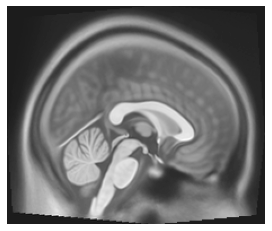

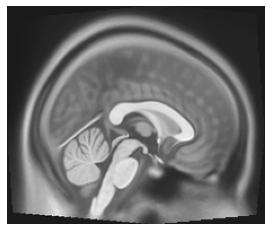

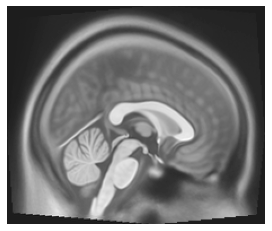

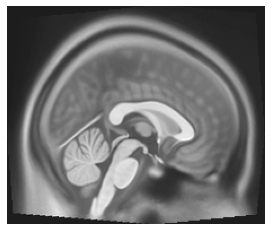

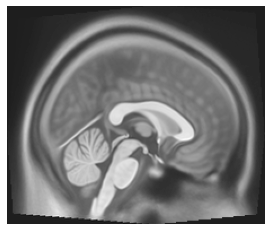

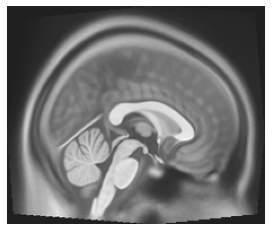

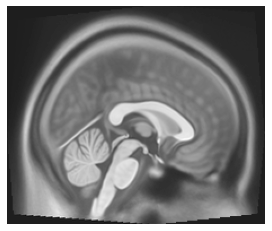

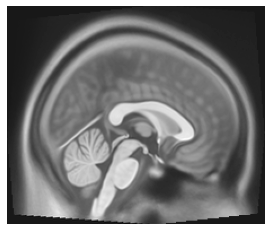

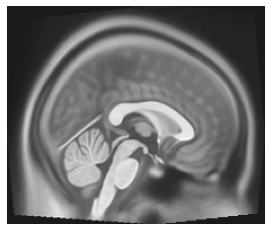

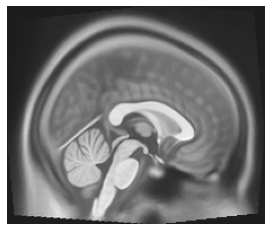

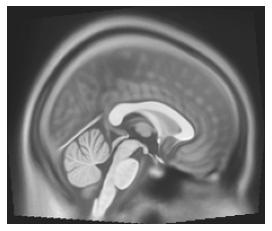

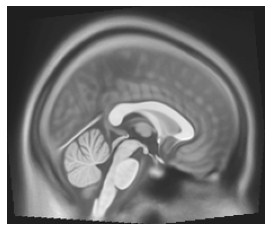

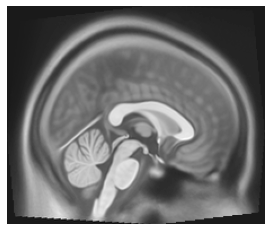

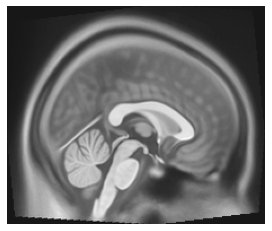

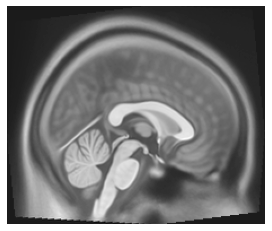

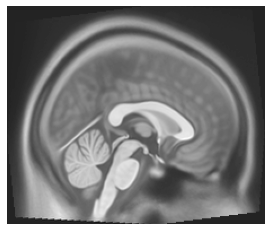

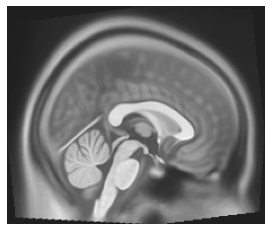

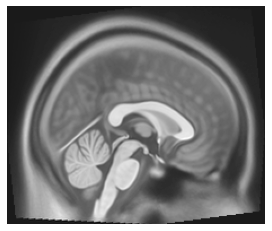

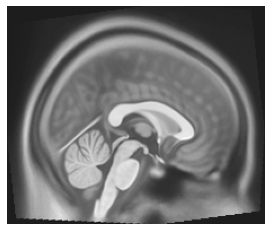

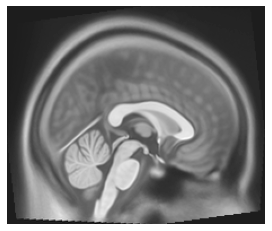

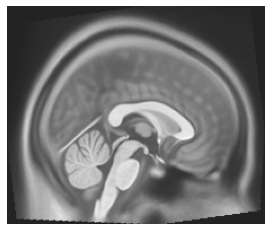

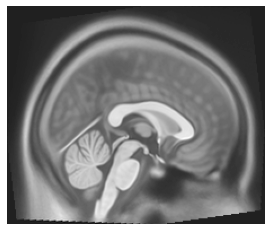

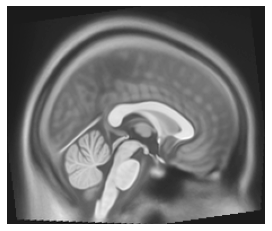

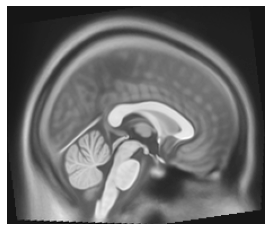

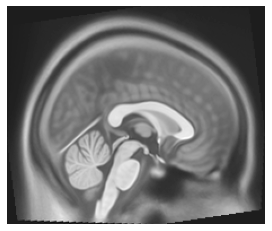

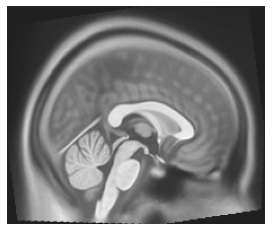

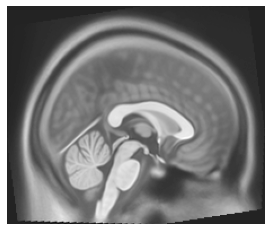

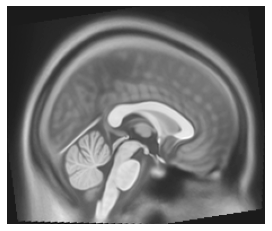

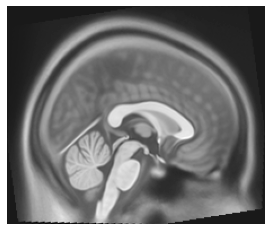

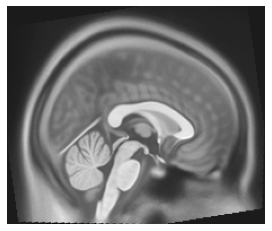

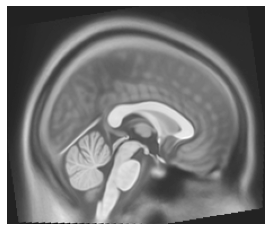

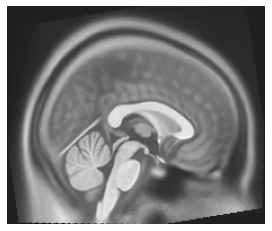

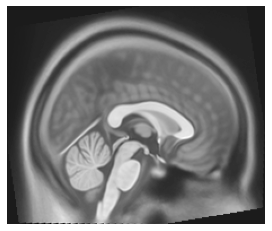

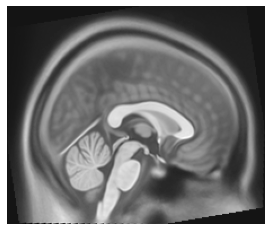

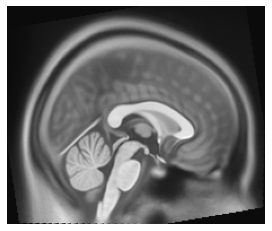

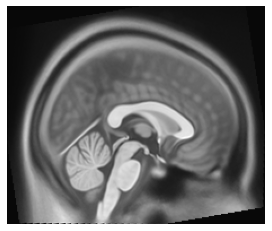

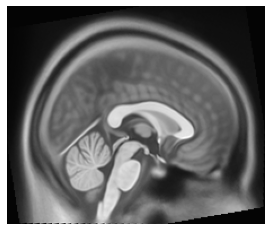

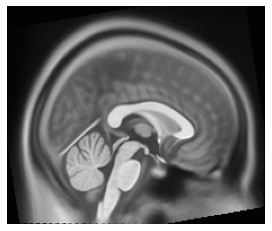

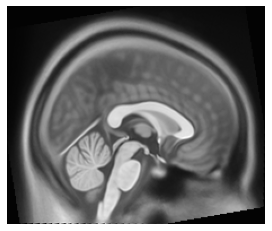

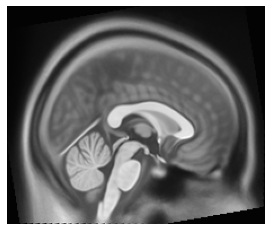

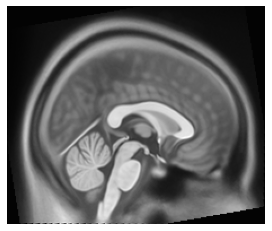

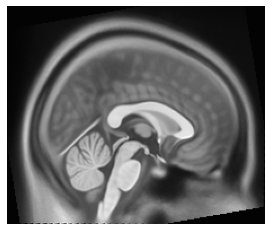

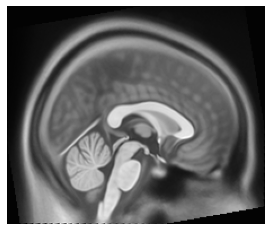

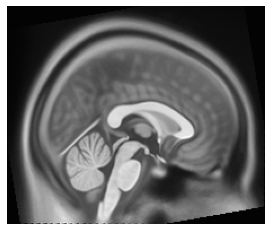

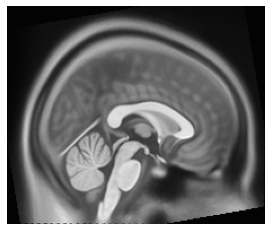

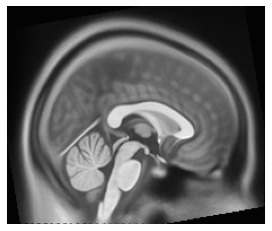

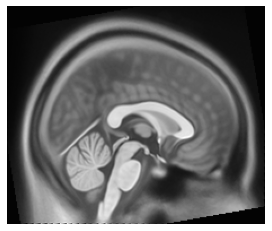

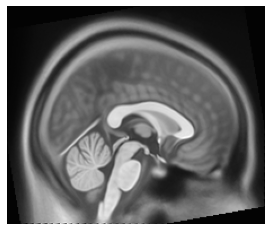

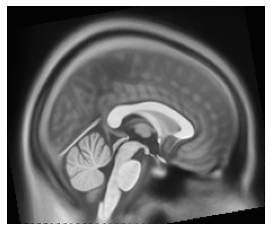

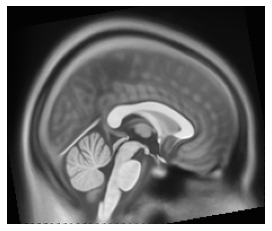

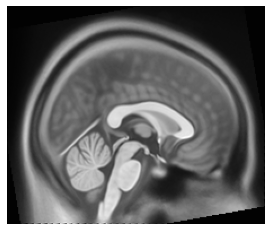

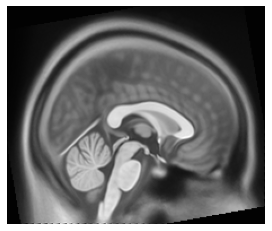

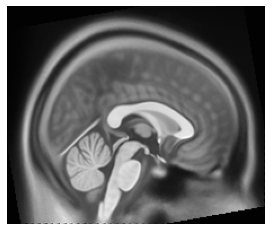

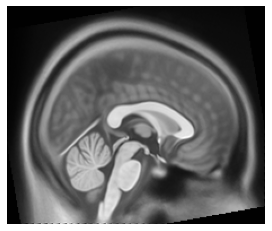

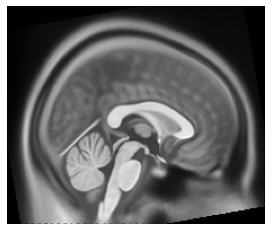

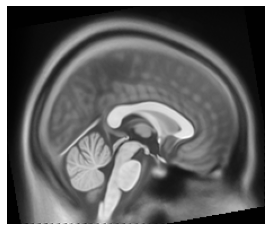

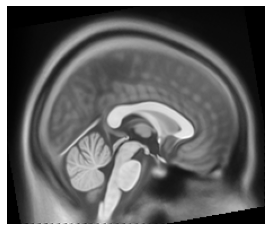

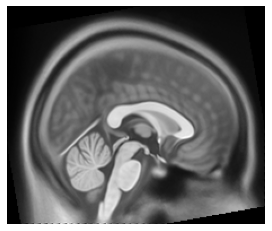

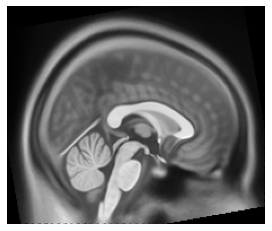

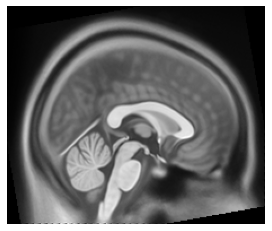

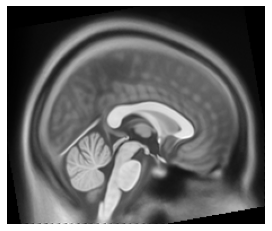

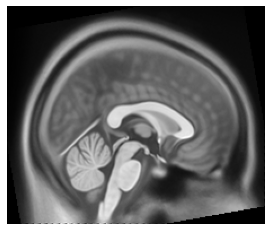

In [8]:
"""
    Run optimization
"""
# With the gradient calculate we can do gradient descent
# we choose a small step size and run for 50 iterations
step_size = 1e-12
ofx = list()
for i in range(100):
    affine_mat = affine_mat - step_size*calculate_gradient(new_moving_img, affine_mat)
    affine_mat[3,3] = 1 # this is to the 4,4 element to be equal to 1
    print(affine_mat)
    
    # apply new affine
    transform_mat = affine_sandwich(affine_mat)
    affine_transform(
        mover_img.get_fdata(),
        transform_mat,
        output=new_moving_img
    )
    
    # display
    display_slice(new_moving_img)
    
    # print objective function value
    value = objective_function(new_moving_img.ravel(),fixed_img.get_fdata().ravel())
    ofx.append(value)

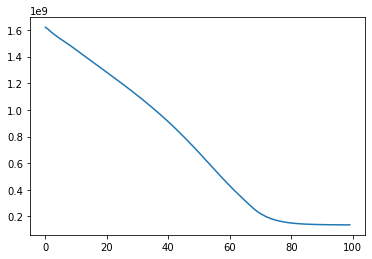

In [9]:
# plot
plt.plot(ofx)
plt.show()